# 全连接神经网络

在前面的作业中，你在CIFAR-10上实现了一个两层的全连接神经网络。那个实现很简单，但不是很模块化，因为损失和梯度计算在一个函数内。对于一个简单的两层网络来说，还可以人为处理，但是当我们使用更大的模型时，人工处理损失和梯度就变得不切实际了。理想情况下，我们希望使用更加模块化的设计来构建网络，这样我们就可以独立地实现不同类型的层，然后将它们整合到不同架构的模型中。

在本练习中，我们将使用更模块化的方法实现全连接网络。对于每一层，我们将实现一个`forward`和一个`backward`的函数。`forward`函数将接收输入、权重和其他参数，并返回一个输出和一个`cache`对象，存储反向传播所需的数据，如下所示：

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

反向传播将接收上游的梯度和`cache`对象，并返回相对于输入和权重的梯度：

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

以这种方式实现了一些层之后，我们能够轻松地将它们组合起来，以构建不同架构的分类器。

除了实现任意深度的全连接网络外，我们还将探索不同的优化更新规则，并引入Dropout作为正则化器和Batch/Layer归一化工具来更有效地优化网络。
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from daseCV.classifiers.fc_net import *
from daseCV.data_utils import get_CIFAR10_data
from daseCV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from daseCV.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the daseCV directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# 仿射层：前向传播
打开 `daseCV/layers.py` 并实现 `affine_forward` 函数。

当你完成上述函数后，你可以用下面的代码测试你的实现正确与否

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)


out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# 仿射层：反向传播
实现 `affine_backwards` 函数，并使用数值梯度检查测试你的实现。

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU 激活函数：前向传播

在`relu_forward`函数中实现ReLU激活函数的前向传播，并使用以下代码测试您的实现:

In [3]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU 激活函数：反向传播

在`relu_back`函数中为ReLU激活函数实现反向传播，并使用数值梯度检查来测试你的实现

In [4]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

作业中只要求你实现ReLU,但是神经网络可以使用很多不同的激活函数,每个都有它的优点和缺点。但是，激活函数的一个常见问题是在反向传播时出现零(或接近零)梯度流。下列哪个激活函数会有这个问题？如果在一维情况下考虑这些函数，什么样的输入将会发生这种现象？
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1. Sigmoid

Sigmoid函数的数学表达式如下，
$$f(x)=\frac{1}{1+e^{-x}}$$
其导数为
$$f^{\prime}(x)=f(x)(1-f(x))$$
当输入x非常大或非常小时，导数都会趋于零。

在一维情况下，例如输入为(-1e6, -1e5, 1e5, 1e6)，将会出现零(或接近零)梯度流。

2. ReLU

ReLU函数的数学表达式如下，
$$f(x)=max(0, x)$$
其导数为
$$f^{\prime}(x)=\begin{cases}
1, & \text{if } x > 0 \\
0, & \text{if } x \leq 0
\end{cases}$$
当输入x小于等于零时，导数会等于零。

在一维情况下，例如输入为(-1, -2, -3, -4)，将会出现零梯度流。

3. Leaky ReLU

Leaky ReLU函数的数学表达式如下，
$$f(x)=max(0.1x, x)$$
其导数为
$$f^{\prime}(x)=\begin{cases}
1, & \text{if } x > 0 \\
0.1, & \text{if } x \leq 0
\end{cases}$$
所以，Leaky ReLU函数通常不会发生出现零(或接近零)梯度流的问题。

# “三明治” 层

在神经网络中有一些常用的层模式。例如，仿射层后面经常跟一个ReLU层。为了简化这些常见模式，我们在文件`daseCV/layer_utils.py`中定义了几个常用的层

请查看 `affine_relu_forward` 和 `affine_relu_backward` 函数, 并且运行下列代码进行数值梯度检查：

In [5]:
from daseCV.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# 损失层：Softmax and SVM

在上次作业中你已经实现了这些损失函数，所以这次作业就不用做了，免费送你了。当然，你仍然应该通过查看`daseCV/layers.py`其中的实现来确保理解它们是如何工作的。

你可以通过运行以下程序来确保实现是正确的:

In [6]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# 两层网络

在之前的作业中，你已经实现了一个简单的两层神经网络。现在你已经模块化地实现了一些层，你将使用这些模块重新实现两层网络。

打开文件`daseCV/classifiers/fc_net`。并完成`TwoLayerNet`类的实现。这个类将作为这个作业中其他网络的模块，所以请通读它以确保你理解了这个API。
你可以运行下面的单元来测试您的实现。


In [4]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.21e-10
b1 relative error: 8.37e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver

在之前的作业中，模型的训练逻辑与模型本身是耦合的。在这次作业中，按照更加模块化的设计，我们将模型的训练逻辑划分为单独的类。

打开文件`daseCV/solver`，通读一遍以熟悉API。然后使用一个`Sovler`实例来训练一个`TwoLayerNet`，它可以在验证集上达到至少`50%`的精度。

In [5]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

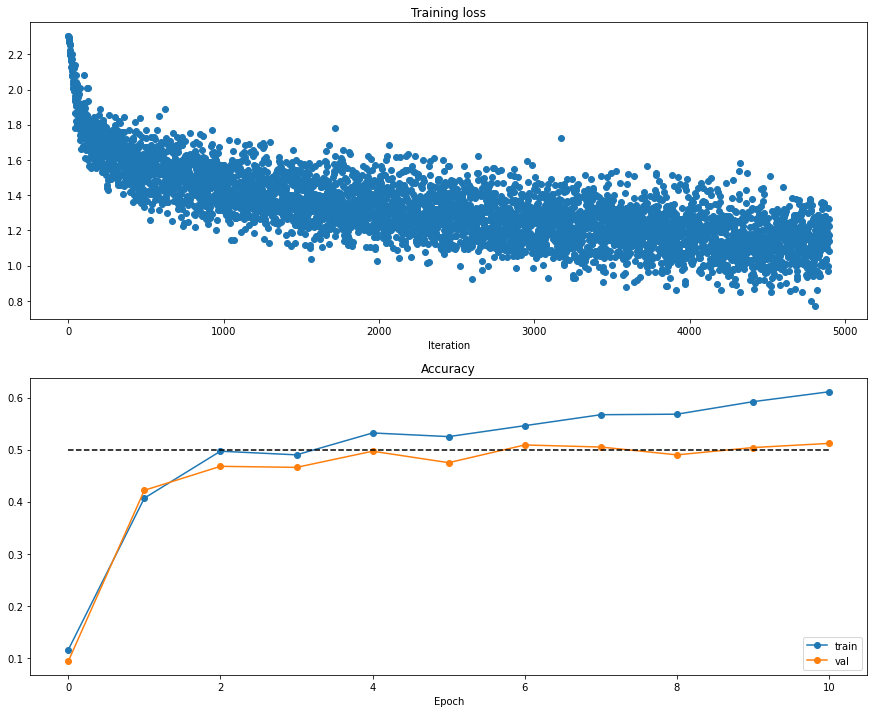

In [6]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# 多层网络

接下来，请实现一个带有任意数量的隐层的全连接网络。

阅读`daseCV/classifiers/fc_net.py`中的`FullyConnectedNet`类。

实现初始化、前向传播和反向传播的函数，暂时不要考虑实现dropout或batch/layer normalization，我们将在后面添加上去。

## 初始化loss和梯度检查

刚开始要做完整性检查，运行以下代码来检查初始loss，并对有正则化和无正则化的网络进行梯度检查。请问初始的loss合理吗?

在梯度检查中，你应该期望得到1e-7或更少的errors。

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


实现另一个完整性检查，请确保你可以过拟合50个图像的小数据集。首先，我们将尝试一个三层网络，每个隐藏层有100个单元。在接下来的代码中，调整**learning rate**和**weight initialization scale**以达到过拟合，在20 epoch内达到100%的训练精度。

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

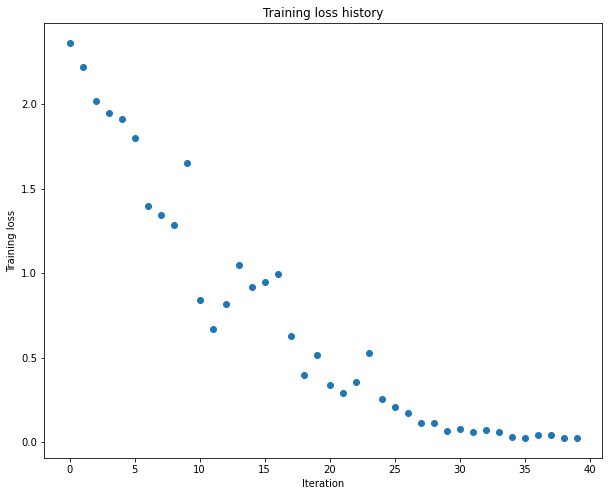

In [6]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

现在尝试使用一个五层的网络，每层100个单元，对50张图片进行训练。同样，你将调整learning rate和weight initialization scale比例，你应该能够在20个epoch内实现100%的训练精度。

(Iteration 1 / 40) loss: 166.501707
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.101000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.122000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.106000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.111000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.113000
(Iteration 11 / 40) loss: 3.343141
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.122000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.113000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.125000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.125000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.121000
(Iteration 21 / 40) loss: 0.039138
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.123000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.121000
(Iteration 31 / 40) loss

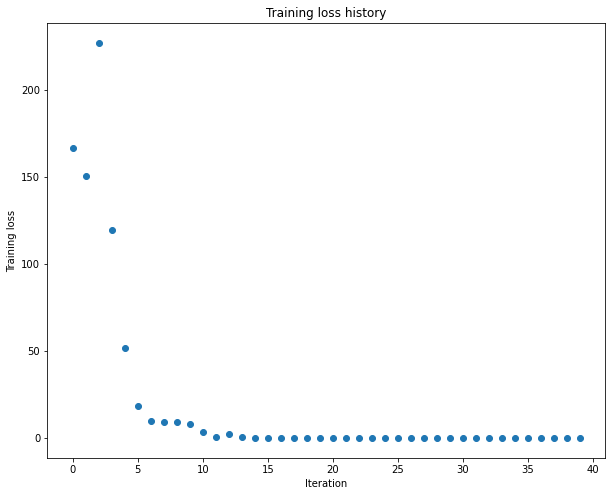

In [7]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1 # Experiment with this!
learning_rate = 2e-3  # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

#### Inline Question 2: 
你注意到训练三层网和训练五层网难度的区别了吗？根据你的经验，哪个网络对initalization scale更敏感?为什么会这样呢?

## Answer:
训练五层网的难度更大。

我认为五层网络对initalization scale更敏感。这可能是由于在更深的神经网络中，梯度在反向传播中需要通过更多的层传递，而如果权重初始化不适当，梯度可能会在传播过程中变得非常小或非常大，从而导致梯度消失或爆炸的问题。


# 更新规则

到目前为止，我们使用了普通的随机梯度下降法(SGD)作为我们的更新规则。更复杂的更新规则可以更容易地训练深度网络。我们将实现一些最常用的更新规则，并将它们与普通的SGD进行比较。

# SGD+Momentum

带动量的随机梯度下降法是一种广泛使用的更新规则，它使深度网络的收敛速度快于普通的随机梯度下降法。更多信息参见http://cs231n.github.io/neural-networks-3/#sgd 动量更新部分。

打开文件`daseCV/optim`，并阅读该文件顶部的文档，以确保你理解了该API。在函数`sgd_momentum`中实现SGD+动量更新规则，并运行以下代码检查你的实现。你会看到errors小于e-8。

In [4]:
from daseCV.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


当你完成了上面的步骤，运行以下代码来训练一个具有SGD和SGD+momentum的六层网络。你应该看到SGD+momentum更新规则收敛得更快。


running with  sgd
(Iteration 1 / 200) loss: 2.643648
(Epoch 0 / 5) train acc: 0.130000; val_acc: 0.118000
(Iteration 11 / 200) loss: 2.329420
(Iteration 21 / 200) loss: 2.246015
(Iteration 31 / 200) loss: 2.094215
(Epoch 1 / 5) train acc: 0.242000; val_acc: 0.231000
(Iteration 41 / 200) loss: 2.132801
(Iteration 51 / 200) loss: 2.137607
(Iteration 61 / 200) loss: 2.096349
(Iteration 71 / 200) loss: 2.000718
(Epoch 2 / 5) train acc: 0.305000; val_acc: 0.265000
(Iteration 81 / 200) loss: 1.874798
(Iteration 91 / 200) loss: 1.814635
(Iteration 101 / 200) loss: 1.901794
(Iteration 111 / 200) loss: 1.876905
(Epoch 3 / 5) train acc: 0.301000; val_acc: 0.282000
(Iteration 121 / 200) loss: 1.867112
(Iteration 131 / 200) loss: 1.921080
(Iteration 141 / 200) loss: 1.910690
(Iteration 151 / 200) loss: 1.807291
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.301000
(Iteration 161 / 200) loss: 1.953227
(Iteration 171 / 200) loss: 1.804051
(Iteration 181 / 200) loss: 1.750016
(Iteration 191 / 200) los

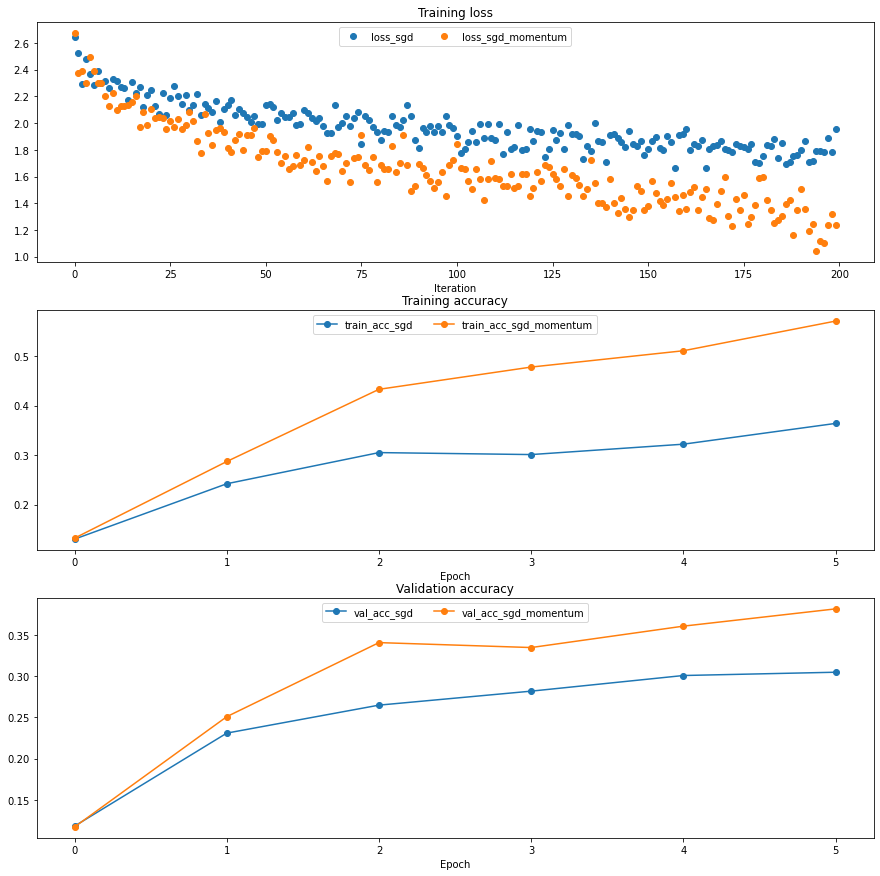

In [5]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam

RMSProp [1] 和Adam [2] 是另外两个更新规则，它们通过使用梯度的二阶矩平均值来设置每个参数的学习速率。

在文件`daseCV/optim`中实现`RMSProp`函数和`Adam`函数，并使用下面的代码来检查您的实现。

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [6]:
# Test RMSProp implementation
from daseCV.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [7]:
# Test Adam implementation
from daseCV.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


当你完成了上面RMSProp和Adam函数后，运行下面的代码训练一对网络，其中分别使用了上述两个方法

running with  adam
(Iteration 1 / 200) loss: 2.790218
(Epoch 0 / 5) train acc: 0.131000; val_acc: 0.162000
(Iteration 11 / 200) loss: 2.010740
(Iteration 21 / 200) loss: 1.935618
(Iteration 31 / 200) loss: 1.863546
(Epoch 1 / 5) train acc: 0.349000; val_acc: 0.319000
(Iteration 41 / 200) loss: 1.970716
(Iteration 51 / 200) loss: 1.891186
(Iteration 61 / 200) loss: 1.671018
(Iteration 71 / 200) loss: 1.450362
(Epoch 2 / 5) train acc: 0.408000; val_acc: 0.371000
(Iteration 81 / 200) loss: 1.495321
(Iteration 91 / 200) loss: 1.691200
(Iteration 101 / 200) loss: 1.374666
(Iteration 111 / 200) loss: 1.441763
(Epoch 3 / 5) train acc: 0.459000; val_acc: 0.374000
(Iteration 121 / 200) loss: 1.430596
(Iteration 131 / 200) loss: 1.430921
(Iteration 141 / 200) loss: 1.380597
(Iteration 151 / 200) loss: 1.165600
(Epoch 4 / 5) train acc: 0.530000; val_acc: 0.375000
(Iteration 161 / 200) loss: 1.328285
(Iteration 171 / 200) loss: 1.222836
(Iteration 181 / 200) loss: 1.328389
(Iteration 191 / 200) lo

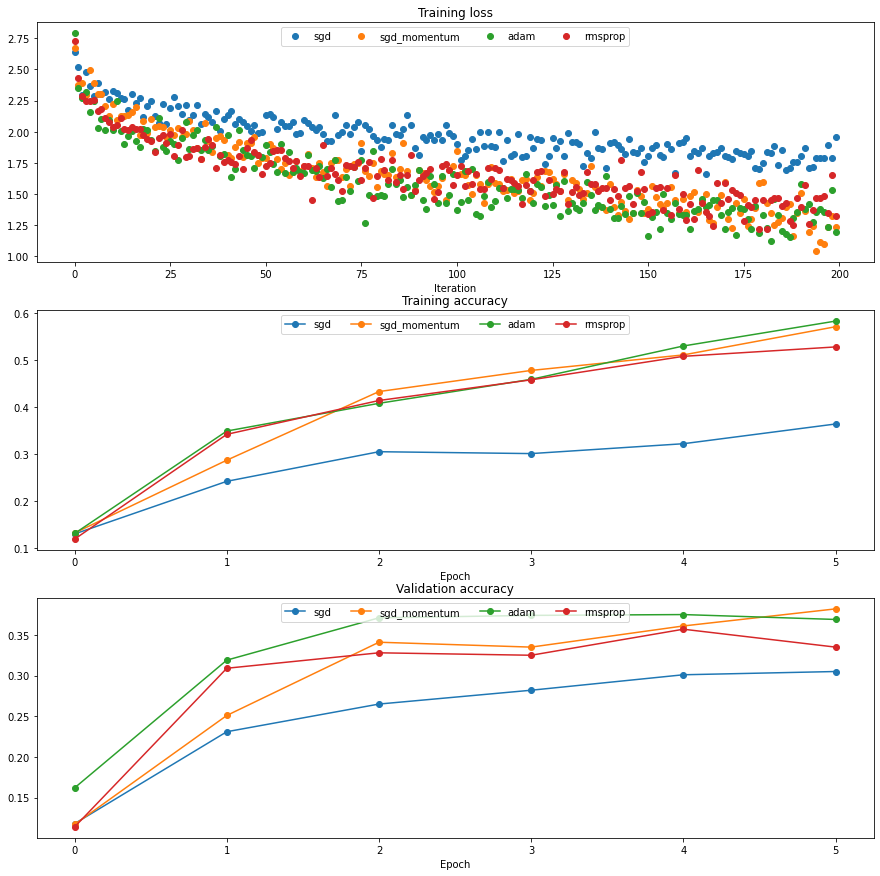

In [8]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad，类似于Adam，是一个per-parameter优化方法，它使用以下更新规则:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

当使用AdaGrad训练一个网络时，更新的值会变得非常小，而且他的网络学习的非常慢。利用你对AdaGrad更新规则的了解，解释为什么更新的值会变得非常小？ Adam会有同样的问题吗？

## Answer: 
因为AdaGrad每次更新的时候，作为分母的一部分的历史梯度平方和（cache）都在增加，这会导致更新变化值变得非常小。

Adam一般不会有同样的问题。因为Adam通过使用一阶矩估计，二阶矩估计和偏差修正来自适应地调整更新变化值。

# 训练一个效果足够好的模型！

在CIFAR-10上尽可能训练最好的全连接模型，将最好的模型存储在`best_model`变量中。我们要求你在验证集上获得至少50%的准确性。

如果你细心的话，应该是有可能得到55%以上精度的，但我们不苛求你达到这么高的精度。在后面的作业上，我们会要求你们在CIFAR-10上训练最好的卷积神经网络，我们希望你们把精力放在卷积网络上，而不是全连接网络上。

在做这部分之前完成`BatchNormalization.ipynb`和`Dropout.ipynb`可能会对你有帮助，因为这些技术可以帮助你训练强大的模型。

In [3]:
best_model = None
best_val_acc = -1
best_ws = -1
best_lr = -1
best_reg = -1
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

weight_scales = [1e-2, 2e-2, 3e-2]
learning_rates = [1e-4, 5e-4, 1e-3]
regularization_strengths = [1e-3, 5e-3, 1e-2]
hidden_dims = [300, 200, 100]

for ws in weight_scales:
    for lr in learning_rates:
        for reg in regularization_strengths:
            model = FullyConnectedNet(hidden_dims=hidden_dims, weight_scale=ws, reg=reg, dropout=0.8, normalization='batchnorm')

            solver = Solver(model, data,
                            num_epochs=20, batch_size=200,
                            update_rule='adam',
                            optim_config={
                              'learning_rate': lr
                            },
                            lr_decay=0.9,
                            verbose=False)
            solver.train()
            val_acc = solver.best_val_acc
            if best_val_acc < val_acc:
                best_val_acc = val_acc
                best_model = model
                best_ws = ws
                best_lr = lr
                best_reg = reg
            print('lr %e ws %e reg %e val accuracy: %f' % (lr, ws, reg, val_acc))
    
print('best validation accuracy achieved:')
print('lr %e ws %e reg %e val accuracy: %f' % (best_lr, best_ws, best_reg, best_val_acc))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-04 ws 1.000000e-02 reg 1.000000e-03 val accuracy: 0.581000
lr 1.000000e-04 ws 1.000000e-02 reg 5.000000e-03 val accuracy: 0.584000
lr 1.000000e-04 ws 1.000000e-02 reg 1.000000e-02 val accuracy: 0.574000
lr 5.000000e-04 ws 1.000000e-02 reg 1.000000e-03 val accuracy: 0.598000
lr 5.000000e-04 ws 1.000000e-02 reg 5.000000e-03 val accuracy: 0.601000
lr 5.000000e-04 ws 1.000000e-02 reg 1.000000e-02 val accuracy: 0.596000
lr 1.000000e-03 ws 1.000000e-02 reg 1.000000e-03 val accuracy: 0.598000
lr 1.000000e-03 ws 1.000000e-02 reg 5.000000e-03 val accuracy: 0.583000
lr 1.000000e-03 ws 1.000000e-02 reg 1.000000e-02 val accuracy: 0.563000
lr 1.000000e-04 ws 2.000000e-02 reg 1.000000e-03 val accuracy: 0.564000
lr 1.000000e-04 ws 2.000000e-02 reg 5.000000e-03 val accuracy: 0.571000
lr 1.000000e-04 ws 2.000000e-02 reg 1.000000e-02 val accuracy: 0.583000
lr 5.000000e-04 ws 2.000000e-02 reg 1.000000e-03 val accuracy: 0.610000
lr 5.000000e-04 ws 2.000000e-02 reg 5.000000e-03 val accuracy: 0

# 测试你的模型！

在验证和测试集上运行您的最佳模型。验证集的准确率应达到50%以上。

In [4]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.6
Test set accuracy:  0.588


---
# Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [5]:
# leaderboard的测试数据
X = np.load("input/test_norm.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的模型
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的best_model。                   
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
leaderboard_model = best_model
preds = np.argmax(leaderboard_model.loss(X), axis=1)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase1的leaderboard中。

In [6]:
import os
#输出格式
def output_file(preds, phase_id=1):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=1):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()